# OpenCV DNN Scene Classification

- use Places365 pre-trained models to analyze scenery
- updated for OpenCV 3.4.2

In [28]:
%reload_ext autoreload
%autoreload 2
import os, sys
from os.path import join
import time
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

import numpy as np
import imutils
import cv2 as cv
if not cv.__version__ == '3.4.2':
  print('pip install opencv-python==3.4.2 or greater')

In [29]:
# append notebook imports folder
sys.path.append(str(Path(os.getcwd()).parent))
from utils import imx

In [30]:
# append vframe imports folder
sys.path.append(str(Path(os.getcwd()).parent.parent/'vframe/'))
from vframe.utils import im_utils, file_utils
from vframe.settings import vframe_cfg as cfg

In [31]:
# Asset directories
# change this to a Model Classification Network object
dir_places365 = join(cfg.DIR_MODELS_VFRAME,'caffe/places365')
dir_googlenet = join(dir_places365,'googlenet_places365')
fp_model = join(dir_googlenet, 'googlenet_places365.caffemodel')
fp_prototxt = join(dir_googlenet,'deploy_googlenet_places365.prototxt')
fp_classes = join(dir_places365,'data/categories_places365.txt')

lines = file_utils.load_text(fp_classes)
classes = [line.strip().split(' ')[0][3:] for line in lines]


In [9]:
net = cv.dnn.readNetFromCaffe(fp_prototxt, fp_model)

In [32]:
cfg.DIR_TEST_IMAGES

'/data_store_ssd/apps/syrianarchive/test/images'

In [33]:
# get a test image
im_test_list = glob(join(cfg.DIR_TEST_IMAGES, 'classify', '*'))
fp_im_test = np.random.choice(im_test_list)

In [37]:
im = cv.imread(fp_im_test)

In `cv2.dnn.blobFromImage` check `deploy.prototxt` for dimensions and mean value.

This CNN requires fixed spatial dimensions for our input image(s) so we need to ensure it is resized to 224x224 pixels while performing mean subtraction (104, 117, 123) to normalize the input; after executing this command our "blob" now has the shape: (1, 3, 224, 224)

If the prototxt file throws an error, try using this at top of file:
```
input: "data"
input_shape {
  dim: 1
  dim: 3
  dim: 224
  dim: 224
}
```

In [40]:
dnn_size = (224, 224)
dnn_mean_clr = (104, 117, 123)
dnn_scale = 1

In [53]:
# calc FPS
niters = 10
st = time.time()
for n in range(niters):
    blob = cv.dnn.blobFromImage(im, dnn_scale, dnn_size, dnn_mean_clr)
    net.setInput(blob)
    preds = net.forward()

fps = float(niters) / (time.time()-st)
print("[INFO] FPS {:.5}".format(fps))

[INFO] FPS 64.578


In [54]:
# probabilitiy first) and grab the top-5 predictions
idxs = np.argsort(preds[0])[::-1][:5]

for idx in idxs:
  print('{} ({:.2f}%)'.format(classes[idx], 100*preds[0][idx]))

loading_dock (18.30%)
construction_site (14.67%)
slum (13.28%)
barndoor (6.68%)
hangar/outdoor (4.74%)


[INFO]1. label: loading_dock, probability: 0.18304
[INFO]2. label: construction_site, probability: 0.14671
[INFO]3. label: slum, probability: 0.13279
[INFO]4. label: barndoor, probability: 0.066759
[INFO]5. label: hangar/outdoor, probability: 0.047387


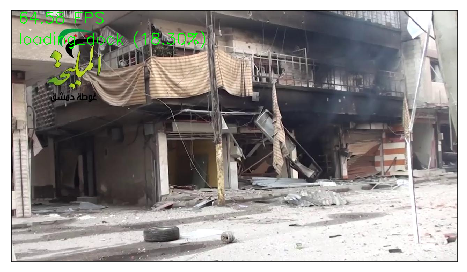

64.58 FPS


<Figure size 432x288 with 0 Axes>

In [55]:
# loop over the top-5 predictions and display them
dst = im.copy()
for (i, idx) in enumerate(idxs):
  # draw the top prediction on the input image
  if i == 0:
      text = "{} ({:.2f}%)".format(classes[idx],
          preds[0][idx] * 100)
      cv.putText(dst, text, (20, 100),  cv.FONT_HERSHEY_SIMPLEX,
          1.5, (0, 255,0), 2)
      cv.putText(dst,'{:.2f} FPS'.format(fps),(20,40),cv.FONT_HERSHEY_SIMPLEX,
          1.5,(0,255,0),2)

  print("[INFO]{}. label: {}, probability: {:.5}".format(i + 1,
      classes[idx], preds[0][idx]))

# # display the output image
imx.pltimg(dst,mode='bgr')
print('{:.2f} FPS'.format(fps))

conv1/7x7_s2
conv1/relu_7x7
pool1/3x3_s2
pool1/norm1
conv2/3x3_reduce
conv2/relu_3x3_reduce
conv2/3x3
conv2/relu_3x3
conv2/norm2
pool2/3x3_s2
inception_3a/1x1
inception_3a/relu_1x1
inception_3a/3x3_reduce
inception_3a/relu_3x3_reduce
inception_3a/3x3
inception_3a/relu_3x3
inception_3a/5x5_reduce
inception_3a/relu_5x5_reduce
inception_3a/5x5
inception_3a/relu_5x5
inception_3a/pool
inception_3a/pool_proj
inception_3a/relu_pool_proj
inception_3a/output
inception_3b/1x1
inception_3b/relu_1x1
inception_3b/3x3_reduce
inception_3b/relu_3x3_reduce
inception_3b/3x3
inception_3b/relu_3x3
inception_3b/5x5_reduce
inception_3b/relu_5x5_reduce
inception_3b/5x5
inception_3b/relu_5x5
inception_3b/pool
inception_3b/pool_proj
inception_3b/relu_pool_proj
inception_3b/output
pool3/3x3_s2
inception_4a/1x1
inception_4a/relu_1x1
inception_4a/3x3_reduce
inception_4a/relu_3x3_reduce
inception_4a/3x3
inception_4a/relu_3x3
inception_4a/5x5_reduce
inception_4a/relu_5x5_reduce
inception_4a/5x5
inception_4a/relu_5x

In [68]:
nlayers = net.getLayerTypes()
print(nlayers)

['Concat', 'Convolution', 'Dropout', 'InnerProduct', 'LRN', 'Pooling', 'ReLU', 'Softmax', '__NetInputLayer__']


In [62]:
last_layer = net.getLayer(3)

In [64]:
print(last_layer.name)

pool1/3x3_s2


In [93]:
# b = net.getLayer('loss3/classifier')
#b = net.getLayer('pool5/drop_7x7_s1')
b = net.getLayer('inception_5b/output')

In [94]:
len(b.blobs)

0